In [ ]:
!pip install pytorch-tabnet optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 348 kB 49.0 MB/s 
     |████████████████████████████████| 209 kB 61.4 MB/s 
     |████████████████████████████████| 81 kB 8.5 MB/s 
     |████████████████████████████████| 78 kB 9.6 MB/s 
     |████████████████████████████████| 49 kB 7.1 MB/s 
     |████████████████████████████████| 147 kB 73.2 MB/s 
     |████████████████████████████████| 112 kB 62.1 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=30ae945c9a6adc9336fa952e4170c63462cfea29b0d33faabb4dbbe16145b61b
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from itertools import chain, combinations
import optuna

In [ ]:
from pytorch_tabnet.augmentations import ClassificationSMOTE

ModuleNotFoundError: ignored

In [ ]:
from pytorch_tabnet.tab_model import TabNetClassifier

from sklearn.impute import SimpleImputer,KNNImputer
from sklearn.preprocessing import OneHotEncoder,StandardScaler,MinMaxScaler,MaxAbsScaler,RobustScaler
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve,f1_score,accuracy_score
from sklearn.linear_model import LogisticRegression
from xgboost import XGBRegressor,XGBClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest, SelectPercentile

import torch
import torch.nn as nn

In [ ]:
from xgboost import plot_importance
from matplotlib import pyplot as plt
import seaborn as sns

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"
!mkdir aug-tabular-playground

In [ ]:
!kaggle competitions download -c tabular-playground-series-aug-2022

  0% 0.00/2.27M [00:00<?, ?B/s]
100% 2.27M/2.27M [00:00<00:00, 153MB/s]


In [ ]:
from zipfile import ZipFile

file_name = "tabular-playground-series-aug-2022.zip"
  
# opening the zip file in READ mode
with ZipFile(file_name, 'r') as zipper:
    # printing all the contents of the zip file
    #zipper.printdir()
    zipper.extractall('aug-tabular-playground')
zipper.close()

In [ ]:
df_org=pd.read_csv("/content/aug-tabular-playground/train.csv")

In [ ]:

df_org['attribute_0_material_5'] = np.where(df_org['attribute_0']=='material_5', 1, 0)
df_org['attribute_0_material_7'] = np.where(df_org['attribute_0']=='material_7', 1, 0)


In [ ]:
# read test data

df_test=pd.read_csv("/content/aug-tabular-playground/test.csv")

In [ ]:
df_test['attribute_0_material_5'] = np.where(df_test['attribute_0']=='material_5', 1, 0)
df_test['attribute_0_material_7'] = np.where(df_test['attribute_0']=='material_7', 1, 0)

In [ ]:
features = ['attribute_0_material_5','attribute_0_material_7','loading', 'measurement_0', 'measurement_1', 'measurement_2',
                'measurement_3', 'measurement_4', 'measurement_5', 'measurement_6',
                'measurement_7', 'measurement_8', 'measurement_9', 'measurement_10',
                'measurement_11', 'measurement_12', 'measurement_13', 'measurement_14',
                'measurement_15', 'measurement_16', 'measurement_17']
cat_features=['attribute_0_material_5','attribute_0_material_7']
num_features = ['loading', 'measurement_0', 'measurement_1', 'measurement_2',
                'measurement_3', 'measurement_4', 'measurement_5', 'measurement_6',
                'measurement_7', 'measurement_8', 'measurement_9', 'measurement_10',
                'measurement_11', 'measurement_12', 'measurement_13', 'measurement_14',
                'measurement_15', 'measurement_16', 'measurement_17']
cat_features=['attribute_0_material_5','attribute_0_material_7']
target_col='failure'
X_check=df_org[features].copy()
y_check=df_org[target_col]

In [ ]:
X_t_copy=df_org[cat_features+num_features].copy()
X_val_copy=df_test[cat_features+num_features].copy()

N_NEIGHBORS=5
imputer=KNNImputer(n_neighbors=N_NEIGHBORS)
X_t_copy_numpy=imputer.fit_transform(X_t_copy[num_features])
X_val_copy_numpy=imputer.transform(X_val_copy[num_features])

scaler=MinMaxScaler()
X_t_copy_numpy=scaler.fit_transform(X_t_copy_numpy)
X_val_copy_numpy=scaler.transform(X_val_copy_numpy)  

X_t_final=pd.concat([X_t_copy[cat_features].reset_index(drop=True),
                        pd.DataFrame(X_t_copy_numpy,columns=num_features)],
                    axis=1)

X_val_final=pd.concat([X_val_copy[cat_features].reset_index(drop=True),
                        pd.DataFrame(X_val_copy_numpy,columns=num_features)],
                    axis=1)
df_t_min_max = X_t_final.agg(['min','max'])
df_val_min_max = X_val_final.agg(['min','max'])
#print(df_t_min_max)
#print(df_val_min_max)

X_t_final['target']=0
X_val_final['target']=1

X_adv_check = pd.concat([X_t_final.reset_index(drop=True).sample(n=20775,random_state=1), 
                            X_val_final.reset_index(drop=True)], 
                            axis=0)
X_adv_check = X_adv_check.sample(frac = 1)

In [ ]:
#X_adv_check.head()
#X_adv_check.loc[X_adv_check.index.duplicated()].shape
X_adv_check.shape

(41550, 22)

IndexError: ignored

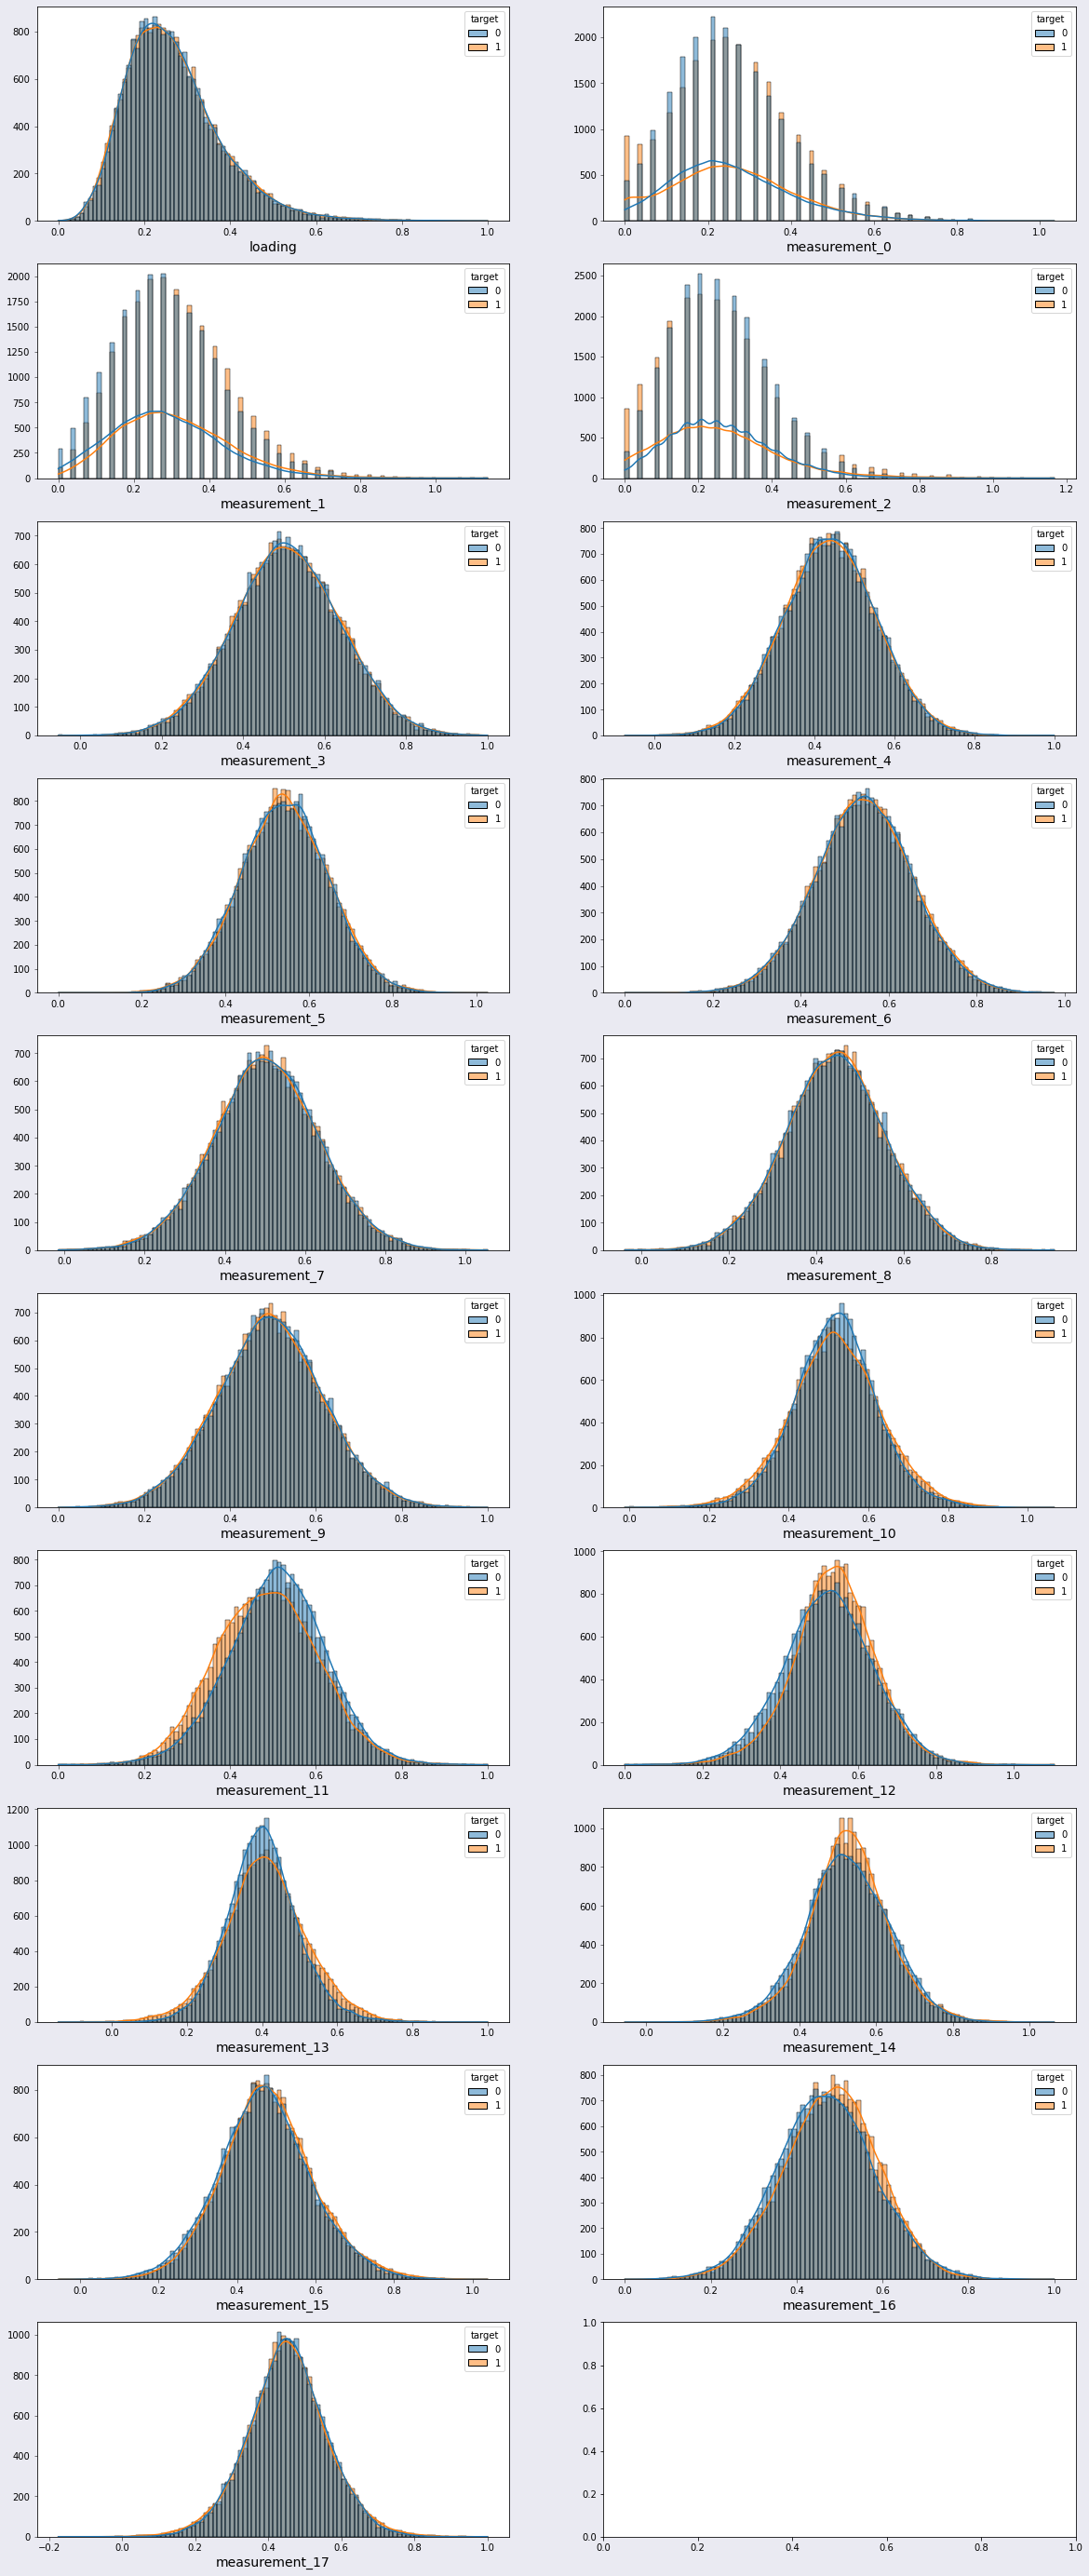

In [ ]:
col_list_1=num_features
ncols = 2
nrows = 10

fig, axes = plt.subplots(nrows, ncols, figsize=(20,50), facecolor='#EAEAF2')

for r in range(nrows):
    for c in range(ncols):
        col = col_list_1[r*ncols+c]
        #print(col)
        sns.histplot(data=X_adv_check.reset_index(drop=True),x=col, bins=100, kde=True, hue='target', legend=True,ax=axes[r, c])
        axes[r, c].set_ylabel('')
        axes[r, c].set_xlabel(col, fontsize=14)
        axes[r, c].tick_params(labelsize=10, width=0.5)
        axes[r, c].xaxis.offsetText.set_fontsize(20)
        axes[r, c].yaxis.offsetText.set_fontsize(20)
plt.show()

In [ ]:
!pip install ctgan
!pip install sdv

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 61 kB 9.6 MB/s 
     |████████████████████████████████| 281 kB 62.4 MB/s 
     |████████████████████████████████| 1.6 MB 50.2 MB/s 
     |████████████████████████████████| 636 kB 66.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0
  Attempting uninstall: psutil
    Found existing installation: psutil 5.4.8
    Uninstalling psutil-5.4.8:
      Successfully uninstalled psutil-5.4.8


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 102 kB 11.5 MB/s 
     |████████████████████████████████| 53 kB 403 kB/s 
     |████████████████████████████████| 47 kB 5.5 MB/s 
     |████████████████████████████████| 1.2 MB 51.0 MB/s 
     |████████████████████████████████| 45 kB 133 kB/s 
     |████████████████████████████████| 98 kB 4.9 MB/s 
     |████████████████████████████████| 11.2 MB 52.0 MB/s 
     |████████████████████████████████| 957 kB 62.2 MB/s 
     |████████████████████████████████| 2.5 MB 50.7 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
  Attempting uninstall: rdt
    Found existing installation: rdt 1.2.0
    Uninstalling rdt-1.2.0:
      Successfully uninstalled rdt-1.2.0
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.1

In [ ]:
from sdv.tabular import CTGAN
from sdv.evaluation import evaluate

In [ ]:
import warnings

warnings.filterwarnings('ignore')

In [ ]:
batch_size = 5000
epochs = 100
model = CTGAN(batch_size=batch_size, epochs=epochs, verbose=True)
model.fit(df_org[features+['failure']])

Epoch 1, Loss G:  0.7573,Loss D: -0.2757
Epoch 2, Loss G:  0.4442,Loss D: -0.6829
Epoch 3, Loss G:  0.0967,Loss D: -0.8495
Epoch 4, Loss G:  0.1018,Loss D: -0.7240
Epoch 5, Loss G:  0.0749,Loss D: -0.4562
Epoch 6, Loss G:  0.1117,Loss D: -0.3066
Epoch 7, Loss G: -0.0830,Loss D:  0.0706
Epoch 8, Loss G: -0.4031,Loss D:  0.2197
Epoch 9, Loss G: -0.5654,Loss D:  0.2666
Epoch 10, Loss G: -0.6521,Loss D:  0.0977
Epoch 11, Loss G: -0.8621,Loss D:  0.1365
Epoch 12, Loss G: -0.9834,Loss D:  0.1684
Epoch 13, Loss G: -1.1666,Loss D:  0.0680
Epoch 14, Loss G: -1.2395,Loss D:  0.0434
Epoch 15, Loss G: -1.3097,Loss D:  0.0198
Epoch 16, Loss G: -1.4334,Loss D:  0.1500
Epoch 17, Loss G: -1.5196,Loss D:  0.1293
Epoch 18, Loss G: -1.4915,Loss D:  0.1359
Epoch 19, Loss G: -1.1421,Loss D: -0.0185
Epoch 20, Loss G: -0.7206,Loss D: -0.1005
Epoch 21, Loss G: -0.7709,Loss D:  0.0449
Epoch 22, Loss G: -0.8895,Loss D:  0.1761
Epoch 23, Loss G: -1.1949,Loss D:  0.3389
Epoch 24, Loss G: -1.3726,Loss D:  0.1297
E

In [ ]:
model.save('ctgan_tabaug2022_model.pkl')

In [ ]:
n_generated_data = 1000
generated_df = model.sample(n_generated_data)

In [ ]:
generated_df.head()

,attribute_0_material_5,attribute_0_material_7,loading,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,measurement_5,measurement_6,...,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure
0,0,0,119.73,19,8,7,14.784,11.755,15.289,16.193,...,13.161,17.722,18.029,11.718,15.780,16.113,17.766,19.206,610.381,0
1,1,1,143.12,10,6,3,17.046,12.398,19.198,17.576,...,11.367,16.676,NaN,10.514,15.660,16.081,16.649,12.628,707.018,0
2,1,1,136.21,7,6,4,17.443,11.672,14.245,17.885,...,10.972,18.412,NaN,11.642,NaN,16.412,15.462,17.081,712.465,0
3,0,1,45.74,18,16,10,17.801,11.174,16.895,18.047,...,11.641,17.990,16.976,12.008,14.309,18.746,15.133,16.512,726.099,0
4,1,1,127.83,29,8,8,18.281,14.052,17.085,17.232,...,11.536,16.924,17.483,11.614,13.715,15.059,NaN,18.486,775.386,1


In [ ]:
generated_df.to_csv("generated_tabaug2022.csv",index=False)

In [ ]:
score = evaluate(generated_df, df_org[features+['failure']].sample(n_generated_data))
score

0.5161959413423235

In [ ]:
#zip -r ctgan_tabaug2022_model.zip ctgan_tabaug2022_model

In [ ]:
new_discrete_features = ['loading_bin', 'measurement_3_bin', 'measurement_4_bin', 'measurement_5_bin', 'measurement_6_bin',
                'measurement_7_bin', 'measurement_8_bin', 'measurement_9_bin', 'measurement_10_bin',
                'measurement_11_bin', 'measurement_12_bin', 'measurement_13_bin', 'measurement_14_bin',
                'measurement_15_bin', 'measurement_16_bin', 'measurement_17_bin']

In [ ]:
QUANTILE_BINS=100
class AddNewFeatures(TransformerMixin):
    def __init__(self):
         None
    def fit(self, X,y=None):
         self.bins_dict={}
         for col in num_features_for_trans:
             q, bins = pd.qcut(X[col], QUANTILE_BINS, retbins=True)
             bins[0]=-np.Inf
             bins[len(bins)-1]=np.Inf
             self.bins_dict[col]=bins
         return self
    def transform(self, X, y=None):
        X_copy=X.copy()
        for col in num_features_for_trans:
            col_bins=self.bins_dict[col]
            bin_labels=np.arange(0,len(col_bins)-1)
            new_col=f"{col}_bin"
            #X[new_col]=pd.qcut(X[col].values, QUANTILE_BINS).codes +1
            X_copy[new_col] = pd.cut(X_copy[col], col_bins, labels=bin_labels,right=False)
        return X_copy

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_org[features], df_org['failure'], 
                                                    test_size=0.33,
                                                    random_state=2,
                                                    stratify=df_org['failure']) 

In [ ]:
N_NEIGHBORS=5
imputer=KNNImputer(n_neighbors=N_NEIGHBORS)
X_train_numpy=imputer.fit_transform(X_train[num_features])
X_test_numpy=imputer.transform(X_test[num_features])
X_train_imputed=pd.concat([X_train[cat_features].copy().reset_index(drop=True),
               pd.DataFrame(X_train_numpy,columns=num_features)],
               axis=1)

X_test_imputed=pd.concat([X_test[cat_features].copy().reset_index(drop=True),
               pd.DataFrame(X_test_numpy,columns=num_features)],
               axis=1)


In [ ]:
df_test=pd.read_csv("/content/aug-tabular-playground/test.csv")
df_test['attribute_0_material_5'] = np.where(df_test['attribute_0']=='material_5', 1, 0)
df_test['attribute_0_material_7'] = np.where(df_test['attribute_0']=='material_7', 1, 0)

df_test_numpy=imputer.transform(df_test[num_features])
df_test_imputed=pd.concat([df_test[cat_features].copy().reset_index(drop=True),
               pd.DataFrame(df_test_numpy,columns=num_features)],
               axis=1)


In [ ]:
col_pair_list=sum([list(map(list, combinations(features, 2)))], [])
def get_interaction_features_pairs(df_org,col_pair_list):
    X_copy=df_org.copy()
    for col_pair in col_pair_list:
        col1,col2=col_pair
        new_col=f"{col1}_{col2}"
        X_copy[new_col]=X_copy[col1]*X_copy[col2]
    return X_copy


In [ ]:
col_triplet_list=sum([list(map(list, combinations(features, 3)))], [])
def get_interaction_features_triplets(df_org,col_triplet_list):
    X_copy=df_org.copy()
    for col_triplet in col_triplet_list:
        col1,col2,col3=col_triplet
        new_col=f"{col1}_{col2}_{col3}"
        X_copy[new_col]=X_copy[col1]*X_copy[col2]*X_copy[col3]
    return X_copy

In [ ]:
X_train_new_feats=get_interaction_features_pairs(X_train_imputed,col_pair_list)
X_test_new_feats=get_interaction_features_pairs(X_test_imputed,col_pair_list)

X_train_new_feats=get_interaction_features_triplets(X_train_new_feats,col_triplet_list)
X_test_new_feats=get_interaction_features_triplets(X_test_new_feats,col_triplet_list)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  import sys


In [ ]:
df_test_new_feats=get_interaction_features_pairs(df_test_imputed,col_triplet_list)
df_test_new_feats=get_interaction_features_triplets(df_test_imputed,col_triplet_list)

In [ ]:
X_train_new_feats.head()

,attribute_0_material_5,attribute_0_material_7,loading,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,measurement_5,measurement_6,...,measurement_13_measurement_14,measurement_13_measurement_15,measurement_13_measurement_16,measurement_13_measurement_17,measurement_14_measurement_15,measurement_14_measurement_16,measurement_14_measurement_17,measurement_15_measurement_16,measurement_15_measurement_17,measurement_16_measurement_17
0,0,1,125.70,4.0,24.0,4.0,16.2250,10.940,16.733,15.485,...,241.088508,225.393649,273.884652,5829.852384,230.502220,280.092276,5961.986592,261.858272,5573.861341,6773.017248
1,1,0,105.34,3.0,5.0,5.0,18.1420,11.201,17.658,17.813,...,239.211336,250.164236,273.008856,13711.951157,244.424544,266.745024,13397.348328,278.958624,14010.780028,15290.223288
2,0,1,141.06,11.0,10.0,3.0,18.1702,12.276,17.754,18.272,...,258.025792,222.456816,247.615360,10514.889216,265.483692,295.508320,12548.644992,254.772360,10818.808416,12042.351360
3,0,1,142.93,3.0,9.0,6.0,19.1240,10.585,17.703,17.519,...,277.456972,214.962670,300.402234,11572.372997,205.240360,286.815672,11048.978876,222.213420,8560.311110,11962.712322
4,1,0,83.18,10.0,7.0,2.0,17.0660,11.927,17.564,16.635,...,264.696340,328.797360,362.672840,12108.011560,307.626876,339.321194,11328.405346,421.493976,14071.784184,15521.578196


In [ ]:
#from sklearn.feature_selection import mutual_info_classif
def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

discrete_features = X_train_new_feats.dtypes == int

mi_scores = make_mi_scores(X_train_new_feats, y_train, discrete_features)
#mi_scores  # show a few features with their MI scores
mi_scores_df=pd.DataFrame({'column':mi_scores.index.tolist(),
                           'mi_score':mi_scores.values.tolist()})
mi_scores_df

,column,mi_score
0,loading_measurement_6_measurement_11,0.019064
1,loading_measurement_15_measurement_17,0.015027
2,loading_measurement_6,0.013974
3,loading_measurement_5_measurement_13,0.013817
4,loading_measurement_7_measurement_8,0.013540
...,...,...
1556,measurement_3_measurement_5_measurement_6,0.000000
1557,attribute_0_material_7_measurement_5_measureme...,0.000000
1558,measurement_3_measurement_5_measurement_8,0.000000
1559,attribute_0_material_7_measurement_5_measureme...,0.000000


In [ ]:
mi_scores_df.to_csv("miscores3interactfeats.csv",index=False)

In [ ]:
from sklearn.feature_selection import SelectKBest, SelectPercentile, mutual_info_classif

selector = SelectKBest(mutual_info_classif, k=300)
X_train_reduced = selector.fit_transform(X_train_new_feats, y_train)
X_test_reduced = selector.transform(X_test_new_feats)



In [ ]:
df_test_reduced = selector.transform(df_test_new_feats)

In [ ]:
print(f"shape of X_train_reduced: {X_train_reduced.shape}")
print(f"shape of X_test_reduced: {X_test_reduced.shape}")

shape of X_train_reduced: (17801, 300)
shape of X_test_reduced: (8769, 300)


In [ ]:

cols = selector.get_support(indices=True)
selected_columns = X_train_new_feats.iloc[:,cols].columns.tolist()
#selected_columns


In [ ]:
scaler=MinMaxScaler()
X_train_numpy=scaler.fit_transform(X_train_reduced)
X_test_numpy=scaler.transform(X_test_reduced)  

X_train_final=pd.DataFrame(X_train_numpy,columns=selected_columns)
X_test_final=pd.DataFrame(X_test_numpy,columns=selected_columns)

In [ ]:
df_test_numpy=scaler.transform(df_test_reduced)  

df_test_final=pd.DataFrame(df_test_numpy,columns=selected_columns)

In [ ]:
def grid_search(param_grid,X,y,random_st):
    clf = LogisticRegression()
    kf = StratifiedKFold(n_splits=5,random_state=random_st,shuffle=True)
    for train_index,test_index in kf.split(X,y):
          
        grid_search =GridSearchCV(clf, 
                                  param_grid = param_grid, 
                                  scoring='roc_auc', 
                                  cv=[(train_index, test_index)])
        grid_search.fit(X, y)
        
        y_pr=grid_search.decision_function(X)
        roc_auc=roc_auc_score(y, y_pr)
        #rand_reg.fit(X[feature_list], y)
        best_params = grid_search.best_params_
        print("Best params:", best_params)
        best_score = grid_search.best_score_
        print("Best score:", best_score)

        print("roc_auc:", roc_auc)

In [ ]:
param_grid2 = [    
    {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
    'max_iter' : [100, 1000,2500, 5000]
    }
]
param_grid = [    
    {'penalty' : ['l1', 'l2', 'elasticnet'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['liblinear'],
    'max_iter' : [100, 250,500,1000,2500, 5000]
    }
]
grid_search(param_grid=param_grid,
            X=X_train_final,
            y=y_train,
            random_st=1)



/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
120 fits failed out of a total of 360.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
120 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 459, in _check_solver
    solver
ValueError: Only 'saga' solv

Best params: {'C': 0.23357214690901212, 'max_iter': 2500, 'penalty': 'l1', 'solver': 'liblinear'}
Best score: 0.5881087029851675
roc_auc: 0.5981297275655526


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
120 fits failed out of a total of 360.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
120 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 459, in _check_solver
    solver
ValueError: Only 'saga' solv

Best params: {'C': 0.03359818286283781, 'max_iter': 500, 'penalty': 'l1', 'solver': 'liblinear'}
Best score: 0.5847094380384104
roc_auc: 0.5931164911360031


In [ ]:
grid_search(params={'C': [0.01,0.05,0.1,0.5,1,5,10,15]},
            X=X_train_reduced,
            y=y_train,
            random_st=1)

#reduced

Best params: {'C': 15}
Best score: 0.5849588340491126
roc_auc: 0.5943273171857186
Best params: {'C': 10}
Best score: 0.581952437259381
roc_auc: 0.5943304085762713
Best params: {'C': 5}
Best score: 0.5908417618224671
roc_auc: 0.5943224727505232
Best params: {'C': 10}
Best score: 0.607227772093591
roc_auc: 0.5943263369887142
Best params: {'C': 1}
Best score: 0.5832531760884616
roc_auc: 0.5943167800679201


In [ ]:
grid_search(params={'C': [0.01,0.05,0.1,0.5,1,5,10,15]},
            X=X_train_final,
            y=y_train,
            random_st=1)

Best params: {'C': 5}
Best score: 0.5853003917784935
roc_auc: 0.5944206809503991
Best params: {'C': 0.1}
Best score: 0.5848838124466568
roc_auc: 0.5929770769620528
Best params: {'C': 0.05}
Best score: 0.5951587066320243
roc_auc: 0.5920778027602348
Best params: {'C': 0.1}
Best score: 0.6090360818353235
roc_auc: 0.5929707999312354
Best params: {'C': 15}
Best score: 0.5833149140546244
roc_auc: 0.5943752525892281


In [ ]:
grid_search(params={'C': [0.01,0.05,0.1,0.5,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]},
            X=X_train_final,
            y=y_train,
            random_st=2)

Best params: {'C': 0.1}
Best score: 0.5886259862773882
roc_auc: 0.5929706114318114
Best params: {'C': 0.1}
Best score: 0.5778211776304969
roc_auc: 0.5929726660755325
Best params: {'C': 0.05}
Best score: 0.5992715862557149
roc_auc: 0.5920607812622525
Best params: {'C': 2}
Best score: 0.5987974763781587
roc_auc: 0.5944032636036265
Best params: {'C': 0.1}
Best score: 0.596910462511623
roc_auc: 0.5929493675467328


In [ ]:
grid_search(params={'C': [0.01,0.05,0.1,0.5,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]},
            X=X_train_final,
            y=y_train,
            random_st=3)

Best params: {'C': 2}
Best score: 0.5850850926304562
roc_auc: 0.5944006246116912
Best params: {'C': 4}
Best score: 0.6033274407350872
roc_auc: 0.5944184001073692
Best params: {'C': 0.05}
Best score: 0.5994798929812415
roc_auc: 0.5920759177659953
Best params: {'C': 0.1}
Best score: 0.5762602910356002
roc_auc: 0.5929789431063499
Best params: {'C': 0.1}
Best score: 0.6004738271082455
roc_auc: 0.5929763418142995


In [ ]:
model = LogisticRegression(C=0.1, penalty='l1', solver='liblinear')
model.fit(X_train_final, y_train)
coef=model.coef_[0]
imp_features=list(pd.Series(X_train_final.columns)[list(coef!=0)])
print(imp_features)
preds=model.predict_proba(X_test_final)[:,1]
roc_auc=roc_auc_score(y_test,preds)
print(roc_auc)

['loading_measurement_3', 'loading_measurement_5', 'loading_measurement_7', 'loading_measurement_8', 'loading_measurement_14', 'loading_measurement_16', 'loading_measurement_17']
0.5851078244601007


<AxesSubplot:xlabel='y_pred', ylabel='Count'>

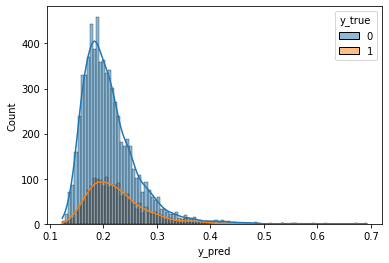

In [ ]:
df_check=pd.DataFrame({'y_pred':preds.tolist(),
                       'y_true':y_test.tolist() })

sns.histplot(data=df_check,x='y_pred', bins=100, kde=True, hue='y_true', legend=True)

In [ ]:
preds_modified=np.where(preds>0.35,0.8,preds)
roc_auc=roc_auc_score(y_test,preds_modified)
roc_auc

0.5851582482060335

In [ ]:
model.predict_proba(X_test_final)[:,1][0:10]


array([0.17735879, 0.16146658, 0.23607932, 0.22250972, 0.21195797,
       0.29951372, 0.15710795, 0.17558532, 0.22097688, 0.25425422])

In [ ]:
model.predict_proba(X_test_final)[:,0][0:10]

array([0.82264121, 0.83853342, 0.76392068, 0.77749028, 0.78804203,
       0.70048628, 0.84289205, 0.82441468, 0.77902312, 0.74574578])

In [ ]:
test_preds=model.predict_proba(df_test_final)[:,1]

<AxesSubplot:ylabel='Count'>

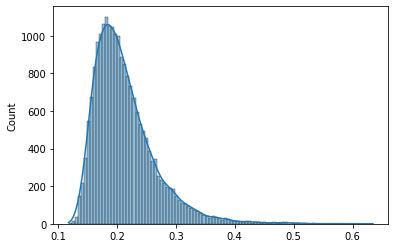

In [ ]:
sns.histplot(x=test_preds, bins=100, kde=True)

In [ ]:
submissions2=pd.DataFrame({'id':df_test['id'].values.tolist(),
                           'failure':test_preds.tolist()})

In [ ]:
submissions2.to_csv("submission_3.csv",index=False)

In [ ]:
def adversarial_check(X_t,X_val,cat_features,num_features):
    X_t_copy=X_t[cat_features+num_features].copy()
    X_val_copy=X_val[cat_features+num_features].copy()

    N_NEIGHBORS=5
    imputer=KNNImputer(n_neighbors=N_NEIGHBORS)
    X_t_copy_numpy=imputer.fit_transform(X_t_copy[num_features])
    X_val_copy_numpy=imputer.transform(X_val_copy[num_features])

    scaler=MinMaxScaler()
    X_t_copy_numpy=scaler.fit_transform(X_t_copy_numpy)
    X_val_copy_numpy=scaler.transform(X_val_copy_numpy)  

    X_t_final=pd.concat([X_t_copy[cat_features].reset_index(drop=True),
                         pd.DataFrame(X_t_copy_numpy,columns=num_features)],
                        axis=1)

    X_val_final=pd.concat([X_val_copy[cat_features].reset_index(drop=True),
                         pd.DataFrame(X_val_copy_numpy,columns=num_features)],
                        axis=1)
    df_t_min_max = X_t_final.agg(['min','max'])
    df_val_min_max = X_val_final.agg(['min','max'])
    print(df_t_min_max)
    print(df_val_min_max)

    X_t_final['target']=1
    X_val_final['target']=0

    X_adv_check = pd.concat([X_t_final.reset_index(drop=True), 
                             X_val_final.reset_index(drop=True)], 
                             axis=0)
    X_adv_check = X_adv_check.sample(frac = 1)

    X_train, X_test, y_train, y_test = train_test_split(X_adv_check.iloc[:,:-1], X_adv_check.iloc[:,-1], 
                                                    test_size=0.33,
                                                    random_state=2,
                                                    stratify=X_adv_check.iloc[:,-1])    
        
    xgb_clf=XGBClassifier()
    #xgb_clf.fit(X_train,y_train)

    scores = cross_val_score(xgb_clf, X_adv_check.iloc[:,:-1], X_adv_check.iloc[:,-1], cv=5)
    print("Mean cross-validation score: %.2f" % scores.mean())
    # plot feature importance
    xgb_clf.fit(X_train,y_train)
    plot_importance(xgb_clf)
    plt.show()

     attribute_0_material_5  attribute_0_material_7  loading  measurement_0  \
min                       0                       0      0.0            0.0   
max                       1                       1      1.0            1.0   

     measurement_1  measurement_2  measurement_3  measurement_4  \
min            0.0            0.0            0.0            0.0   
max            1.0            1.0            1.0            1.0   

     measurement_5  measurement_6  ...  measurement_8  measurement_9  \
min            0.0            0.0  ...            0.0            0.0   
max            1.0            1.0  ...            1.0            1.0   

     measurement_10  measurement_11  measurement_12  measurement_13  \
min             0.0             0.0             0.0             0.0   
max             1.0             1.0             1.0             1.0   

     measurement_14  measurement_15  measurement_16  measurement_17  
min             0.0             0.0             0.0        

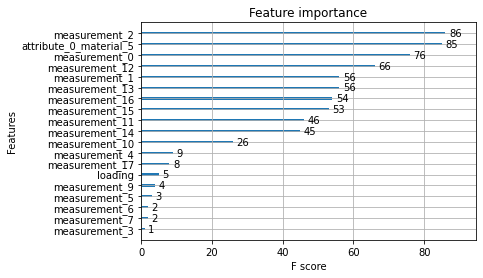

In [ ]:
adversarial_check(df_org,df_test,cat_features,num_features)

In [ ]:
#da

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2,
                                                    random_state=2,
                                                    stratify=y)

print(f"shape of X_train: {X_train.shape}")
print(f"shape of X_test: {X_test.shape}")

print(f"shape of y_train: {y_train.shape}")
print(f"shape of y_test: {y_test.shape}")

In [ ]:
N_NEIGHBORS=5

imputer=KNNImputer(n_neighbors=N_NEIGHBORS)
X_train_trans = imputer.fit_transform(X_train[num_features])
#X_test = imputer.transform(X_test[num_features])


X_train=pd.concat([X_train[cat_features].reset_index(drop=True),pd.DataFrame(X_train_trans,columns=num_features)],axis=1)

In [ ]:
scaler = MinMaxScaler()

X_train_trans = scaler.fit_transform(X_train[num_features])
#df_test_trans = scaler.transform(df_test[num_features])

#Seeing the scaled values of X_train
X_train=pd.concat([X_train[cat_features].reset_index(drop=True),pd.DataFrame(X_train_trans,columns=num_features)],axis=1)
df_test=pd.concat([df_test[cat_features].reset_index(drop=True),pd.DataFrame(df_test_trans,columns=num_features)],axis=1)

,loading,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,measurement_5,measurement_6,measurement_7,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17
0,-1.222832,-0.101025,-0.055370,-0.681939,0.248179,0.789117,-1.384796,1.788466,0.022358,1.120680,-0.759395,-0.184011,-1.037699,2.344516,-0.540071,NaN,-1.266177,-1.039690,0.509571
1,-1.100103,1.599402,-1.246039,-0.984141,0.420975,-0.192746,0.591328,0.383792,1.030535,-1.126062,1.018175,1.301105,-0.826619,0.035287,-0.797164,-0.417888,-0.387656,-0.485533,-0.155814
2,-1.163133,1.113565,-1.722306,-0.379737,0.265159,-0.080304,-0.391214,0.732199,1.000559,-0.730453,1.285411,-0.363249,NaN,1.407525,0.915923,1.731060,-0.581950,0.869140,-0.307320
3,-0.685543,1.356484,-1.484172,-0.077535,-0.495942,-0.546137,1.453436,0.831601,0.865669,0.034986,1.041195,0.162374,-0.522823,-1.130075,-0.348767,-0.326058,0.747773,0.416217,1.013879
4,1.543297,0.384811,-1.484172,0.526868,1.552639,1.222823,-0.138302,-1.771917,-0.410289,-0.923795,-1.094691,0.685863,0.499696,0.487326,0.458003,-2.204209,-1.189363,-0.028514,-0.984448


In [ ]:
df_org.head()

,id,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,...,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure,attribute_0_material_5,attribute_0_material_7
0,0,A,80.10,material_7,material_8,9,5,7,8,4,...,17.594,15.193,15.029,NaN,13.034,14.684,764.100,0,0,1
1,1,A,84.89,material_7,material_8,9,5,14,3,3,...,17.915,11.755,14.732,15.425,14.395,15.631,682.057,0,0,1
2,2,A,82.43,material_7,material_8,9,5,12,1,5,...,NaN,13.798,16.711,18.631,14.094,17.946,663.376,0,0,1
3,3,A,101.07,material_7,material_8,9,5,13,2,6,...,18.377,10.020,15.250,15.562,16.154,17.172,826.282,0,0,1
4,4,A,188.06,material_7,material_8,9,5,9,2,8,...,19.932,12.428,16.182,12.760,13.153,16.412,579.885,0,0,1


In [ ]:
num_features = ['loading', 'measurement_0', 'measurement_1', 'measurement_2',
                'measurement_3', 'measurement_4', 'measurement_5', 'measurement_6',
                'measurement_7', 'measurement_8', 'measurement_9', 'measurement_10',
                'measurement_11', 'measurement_12', 'measurement_13', 'measurement_14',
                'measurement_15', 'measurement_16', 'measurement_17']
cat_features =  ['attribute_0_material_5', 'attribute_0_material_7']

features = num_features+cat_features


In [ ]:
df_org['failure'].value_counts()

0    20921
1     5649
Name: failure, dtype: int64

In [ ]:
df_plot=pd.concat([df_org.loc[df_org['failure']==0].sample(n=5649, random_state=1), 
                    df_org.loc[df_org['failure']==1]], axis=0)
df_plot=df_plot.sample(frac=1,random_state=1)

In [ ]:
df_plot.failure.value_counts()

0    5649
1    5649
Name: failure, dtype: int64

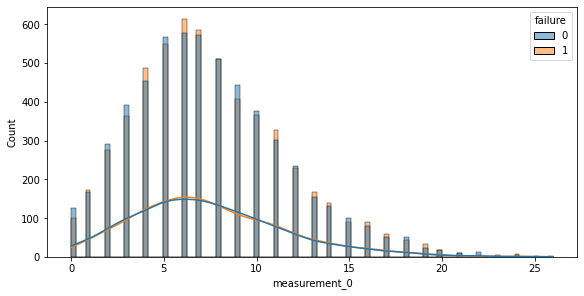

In [ ]:
fig = plt.figure(constrained_layout=True, figsize=(8, 4))
spec = fig.add_gridspec(1, 2)

ax = fig.add_subplot(spec[0, :])
sns.histplot(df_plot, x='measurement_0', bins=100, kde=True, hue='failure', legend=True, ax=ax)
#ax.legend([0,1], title='Failure', prop={'size': 12})
plt.show()

In [ ]:
bins = [-np.Inf,  -6, -5.5,-5,-4.5,-4,-3.5,-3,-2,0]
bin_labels = ['bin_1','bin_2','bin_3','bin_4','bin_5','bin_6','bin_7','bin_8','bin_9']
df_train['click_rate_cut'] = pd.cut(df_train['click_rate_log'], bins=bins, labels=bin_labels,right=False)

In [ ]:
df_plot['measurement_10_quant'] = pd.qcut(df_plot['measurement_3'].values, 19).codes +1

In [ ]:
for col in num_features:
    print(f'{col}: {df_org[col].nunique()}')
    print(f'{col}: {df_org[col].isna().sum()}')

loading: 11950
loading: 250
measurement_0: 29
measurement_0: 0
measurement_1: 30
measurement_1: 0
measurement_2: 25
measurement_2: 0
measurement_3: 4721
measurement_3: 381
measurement_4: 4692
measurement_4: 538
measurement_5: 4671
measurement_5: 676
measurement_6: 4704
measurement_6: 796
measurement_7: 4734
measurement_7: 937
measurement_8: 4713
measurement_8: 1048
measurement_9: 4708
measurement_9: 1227
measurement_10: 6177
measurement_10: 1300
measurement_11: 6526
measurement_11: 1468
measurement_12: 6392
measurement_12: 1601
measurement_13: 5271
measurement_13: 1774
measurement_14: 6389
measurement_14: 1874
measurement_15: 6577
measurement_15: 2009
measurement_16: 7035
measurement_16: 2110
measurement_17: 23612
measurement_17: 2284


In [ ]:
for col in num_features_for_trans:
    new_col=f"{col}_quant"
    df_trans[new_col]=pd.qcut(df_trans[col].values, 19)
    print(f'{col}: {df_trans[new_col].unique()}')
    #print(f'{col}: {df_org[col].isna().sum()}')

loading: [(75.947, 84.32], (84.32, 90.841], (96.235, 101.43], (177.463, 198.086], (33.159, 75.947], ..., (110.71, 115.26], (140.76, 147.12], (147.12, 154.77], (129.781, 135.104], (119.97, 124.87]]
Length: 19
Categories (19, interval[float64, right]): [(33.159, 75.947] < (75.947, 84.32] < (84.32, 90.841] <
                                            (90.841, 96.235] ... (154.77, 164.37] <
                                            (164.37, 177.463] < (177.463, 198.086] <
                                            (198.086, 385.86]]
measurement_3: [(17.98, 18.111], (18.111, 18.261], (17.166, 17.324], (19.044, 19.416], (17.464, 17.594], ..., (16.544, 16.799], (13.967, 16.179], (18.417, 18.586], (18.586, 18.796], (16.179, 16.544]]
Length: 19
Categories (19, interval[float64, right]): [(13.967, 16.179] < (16.179, 16.544] < (16.544, 16.799] <
                                            (16.799, 16.998] ... (18.586, 18.796] <
                                            (18.796, 19.044] < (1

In [ ]:
q, bins = pd.qcut(df_trans['loading'], 20, retbins=True)
bins

array([ 33.16  ,  75.43  ,  83.639 ,  89.9235,  95.24  , 100.2025,
       104.79  , 109.0615, 113.43  , 117.9005, 122.53  , 127.04  ,
       131.904 , 137.04  , 142.64  , 148.88  , 156.662 , 166.253 ,
       178.913 , 199.861 , 385.86  ])

In [ ]:
bins[0]=-np.Inf
bins[len(bins)-1]=np.Inf
bins

array([    -inf,  75.43  ,  83.639 ,  89.9235,  95.24  , 100.2025,
       104.79  , 109.0615, 113.43  , 117.9005, 122.53  , 127.04  ,
       131.904 , 137.04  , 142.64  , 148.88  , 156.662 , 166.253 ,
       178.913 , 199.861 ,      inf])

In [ ]:
#bin_labels =np.linspace(1,len(bins)-1,num=len(bins)-1)
bin_labels=np.arange(0,len(bins)-1)
len(bin_labels)

20

In [ ]:
df_test=pd.read_csv("/content/aug-tabular-playground/test.csv")

In [ ]:

df_test['loading_bin']=pd.cut(np.array(df_test['loading']), bins, labels=bin_labels,right=False)

df_test['loading_bin'].value_counts()

0     1099
4     1098
18    1082
5     1065
14    1063
3     1047
1     1041
8     1040
9     1038
11    1028
19    1024
16    1017
17    1006
15    1004
2     1001
10    1001
12     995
7      982
13     961
6      960
Name: loading_bin, dtype: int64

In [ ]:
#https://stackoverflow.com/questions/36858510/how-transform-value-column-to-quantile-at-pandas-python
num_features_for_trans = ['measurement_3', 'measurement_4', 'measurement_5', 'measurement_6',
                'measurement_7', 'measurement_8', 'measurement_9', 'measurement_10',
                'measurement_11', 'measurement_12', 'measurement_13', 'measurement_14',
                'measurement_15', 'measurement_16', 'measurement_17','loading']

QUANTILE_BINS=20
class AddNewFeatures(TransformerMixin):
    def __init__(self):
         None
    def fit(self, X,y=None):
         self.bins_dict={}
         for col in num_features_for_trans:
             q, bins = pd.qcut(X[col], QUANTILE_BINS, retbins=True)
             bins[0]=-np.Inf
             bins[len(bins)-1]=np.Inf
             self.bins_dict[col]=bins
         return self
    def transform(self, X, y=None):
        X_copy=X.copy()
        for col in num_features_for_trans:
            col_bins=self.bins_dict[col]
            bin_labels=np.arange(0,len(col_bins)-1)
            new_col=f"{col}_bin"
            #X[new_col]=pd.qcut(X[col].values, QUANTILE_BINS).codes +1
            X_copy[new_col] = pd.cut(X_copy[col], col_bins, labels=bin_labels,right=False)
        return X_copy

In [ ]:
pd.options.display.max_columns = None

#interaction term
num_features_for_trans = ['measurement_3', 'measurement_4', 'measurement_5', 'measurement_6',
                'measurement_7', 'measurement_8', 'measurement_9', 'measurement_10',
                'measurement_11', 'measurement_12', 'measurement_13', 'measurement_14',
                'measurement_15', 'measurement_16', 'measurement_17','loading']

all_num_features= ['measurement_0', 'measurement_1', 'measurement_2']+num_features_for_trans

col_pair_list=sum([list(map(list, combinations(all_num_features, 2)))], [])

X_check=df_org.copy()
for col_pair in col_pair_list:
    col1,col2=col_pair
    new_col=f"{col1}_{col2}"
    X_check[new_col]=X_check[col1]*X_check[col2]

X_check.head()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


,id,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,measurement_5,measurement_6,measurement_7,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure,measurement_0_measurement_1,measurement_0_measurement_2,measurement_0_measurement_3,measurement_0_measurement_4,measurement_0_measurement_5,measurement_0_measurement_6,measurement_0_measurement_7,measurement_0_measurement_8,measurement_0_measurement_9,measurement_0_measurement_10,measurement_0_measurement_11,measurement_0_measurement_12,measurement_0_measurement_13,measurement_0_measurement_14,measurement_0_measurement_15,measurement_0_measurement_16,measurement_0_measurement_17,measurement_0_loading,measurement_1_measurement_2,measurement_1_measurement_3,measurement_1_measurement_4,measurement_1_measurement_5,measurement_1_measurement_6,measurement_1_measurement_7,measurement_1_measurement_8,measurement_1_measurement_9,measurement_1_measurement_10,measurement_1_measurement_11,measurement_1_measurement_12,measurement_1_measurement_13,measurement_1_measurement_14,measurement_1_measurement_15,measurement_1_measurement_16,measurement_1_measurement_17,measurement_1_loading,measurement_2_measurement_3,measurement_2_measurement_4,measurement_2_measurement_5,measurement_2_measurement_6,measurement_2_measurement_7,measurement_2_measurement_8,measurement_2_measurement_9,measurement_2_measurement_10,measurement_2_measurement_11,measurement_2_measurement_12,measurement_2_measurement_13,measurement_2_measurement_14,measurement_2_measurement_15,measurement_2_measurement_16,measurement_2_measurement_17,measurement_2_loading,measurement_3_measurement_4,measurement_3_measurement_5,measurement_3_measurement_6,measurement_3_measurement_7,measurement_3_measurement_8,measurement_3_measurement_9,measurement_3_measurement_10,measurement_3_measurement_11,measurement_3_measurement_12,measurement_3_measurement_13,measurement_3_measurement_14,measurement_3_measurement_15,measurement_3_measurement_16,measurement_3_measurement_17,measurement_3_loading,measurement_4_measurement_5,measurement_4_measurement_6,measurement_4_measurement_7,measurement_4_measurement_8,measurement_4_measurement_9,measurement_4_measurement_10,measurement_4_measurement_11,measurement_4_measurement_12,measurement_4_measurement_13,measurement_4_measurement_14,measurement_4_measurement_15,measurement_4_measurement_16,measurement_4_measurement_17,measurement_4_loading,measurement_5_measurement_6,measurement_5_measurement_7,measurement_5_measurement_8,measurement_5_measurement_9,measurement_5_measurement_10,measurement_5_measurement_11,measurement_5_measurement_12,measurement_5_measurement_13,measurement_5_measurement_14,measurement_5_measurement_15,measurement_5_measurement_16,measurement_5_measurement_17,measurement_5_loading,measurement_6_measurement_7,measurement_6_measurement_8,measurement_6_measurement_9,measurement_6_measurement_10,measurement_6_measurement_11,measurement_6_measurement_12,measurement_6_measurement_13,measurement_6_measurement_14,measurement_6_measurement_15,measurement_6_measurement_16,measurement_6_measurement_17,measurement_6_loading,measurement_7_measurement_8,measurement_7_measurement_9,measurement_7_measurement_10,measurement_7_measurement_11,measurement_7_measurement_12,measurement_7_measurement_13,measurement_7_measurement_14,measurement_7_measurement_15,measurement_7_measurement_16,measurement_7_measurement_17,measurement_7_loading,measurement_8_measurement_9,measurement_8_measurement_10,measurement_8_measurement_11,measurement_8_measurement_12,measurement_8_measurement_13,measurement_8_measurement_14,measurement_8_measurement_15,measurement_8_measurement_16,measurement_8_measurement_17,measurement_8_loading,measurement_9_measurement_10,measurement_9_measurement_11,measurement_9_measurement_12,measurement_9_measurement_

In [ ]:
df_org['measurement_2'].isna().sum()

0

In [ ]:
interaction_features=['measurement_0_measurement_1', 'measurement_0_measurement_2', 'measurement_0_measurement_3', 'measurement_0_measurement_4',
 'measurement_0_measurement_5', 'measurement_0_measurement_6', 'measurement_0_measurement_7', 'measurement_0_measurement_8',
 'measurement_0_measurement_9', 'measurement_0_measurement_10', 'measurement_0_measurement_11', 'measurement_0_measurement_12',
 'measurement_0_measurement_13', 'measurement_0_measurement_14', 'measurement_0_measurement_15', 'measurement_0_measurement_16',
 'measurement_0_measurement_17', 'measurement_0_loading', 'measurement_1_measurement_2', 'measurement_1_measurement_3',
 'measurement_1_measurement_4', 'measurement_1_measurement_5', 'measurement_1_measurement_6', 'measurement_1_measurement_7',
 'measurement_1_measurement_8', 'measurement_1_measurement_9', 'measurement_1_measurement_10', 'measurement_1_measurement_11',
 'measurement_1_measurement_12', 'measurement_1_measurement_13', 'measurement_1_measurement_14', 'measurement_1_measurement_15',
 'measurement_1_measurement_16', 'measurement_1_measurement_17', 'measurement_1_loading', 'measurement_2_measurement_3',
 'measurement_2_measurement_4', 'measurement_2_measurement_5', 'measurement_2_measurement_6', 'measurement_2_measurement_7',
 'measurement_2_measurement_8', 'measurement_2_measurement_9', 'measurement_2_measurement_10', 'measurement_2_measurement_11',
 'measurement_2_measurement_12', 'measurement_2_measurement_13', 'measurement_2_measurement_14', 'measurement_2_measurement_15',
 'measurement_2_measurement_16', 'measurement_2_measurement_17', 'measurement_2_loading', 'measurement_3_measurement_4',
 'measurement_3_measurement_5', 'measurement_3_measurement_6', 'measurement_3_measurement_7', 'measurement_3_measurement_8',
 'measurement_3_measurement_9', 'measurement_3_measurement_10', 'measurement_3_measurement_11', 'measurement_3_measurement_12',
 'measurement_3_measurement_13', 'measurement_3_measurement_14', 'measurement_3_measurement_15', 'measurement_3_measurement_16',
 'measurement_3_measurement_17', 'measurement_3_loading', 'measurement_4_measurement_5', 'measurement_4_measurement_6',
 'measurement_4_measurement_7', 'measurement_4_measurement_8', 'measurement_4_measurement_9', 'measurement_4_measurement_10',
 'measurement_4_measurement_11', 'measurement_4_measurement_12', 'measurement_4_measurement_13', 'measurement_4_measurement_14',
 'measurement_4_measurement_15', 'measurement_4_measurement_16', 'measurement_4_measurement_17', 'measurement_4_loading',
 'measurement_5_measurement_6', 'measurement_5_measurement_7', 'measurement_5_measurement_8', 'measurement_5_measurement_9',
 'measurement_5_measurement_10', 'measurement_5_measurement_11', 'measurement_5_measurement_12', 'measurement_5_measurement_13',
 'measurement_5_measurement_14', 'measurement_5_measurement_15', 'measurement_5_measurement_16', 'measurement_5_measurement_17',
 'measurement_5_loading', 'measurement_6_measurement_7', 'measurement_6_measurement_8', 'measurement_6_measurement_9',
 'measurement_6_measurement_10', 'measurement_6_measurement_11', 'measurement_6_measurement_12', 'measurement_6_measurement_13',
 'measurement_6_measurement_14', 'measurement_6_measurement_15', 'measurement_6_measurement_16', 'measurement_6_measurement_17',
 'measurement_6_loading', 'measurement_7_measurement_8', 'measurement_7_measurement_9', 'measurement_7_measurement_10',
 'measurement_7_measurement_11', 'measurement_7_measurement_12', 'measurement_7_measurement_13', 'measurement_7_measurement_14',
 'measurement_7_measurement_15', 'measurement_7_measurement_16', 'measurement_7_measurement_17', 'measurement_7_loading',
 'measurement_8_measurement_9', 'measurement_8_measurement_10', 'measurement_8_measurement_11', 'measurement_8_measurement_12',
 'measurement_8_measurement_13', 'measurement_8_measurement_14', 'measurement_8_measurement_15', 'measurement_8_measurement_16',
 'measurement_8_measurement_17', 'measurement_8_loading', 'measurement_9_measurement_10', 'measurement_9_measurement_11',
 'measurement_9_measurement_12', 'measurement_9_measurement_13', 'measurement_9_measurement_14', 'measurement_9_measurement_15',
 'measurement_9_measurement_16', 'measurement_9_measurement_17', 'measurement_9_loading', 'measurement_10_measurement_11',
 'measurement_10_measurement_12', 'measurement_10_measurement_13', 'measurement_10_measurement_14', 'measurement_10_measurement_15',
 'measurement_10_measurement_16', 'measurement_10_measurement_17', 'measurement_10_loading', 'measurement_11_measurement_12',
 'measurement_11_measurement_13', 'measurement_11_measurement_14', 'measurement_11_measurement_15', 'measurement_11_measurement_16',
 'measurement_11_measurement_17', 'measurement_11_loading', 'measurement_12_measurement_13', 'measurement_12_measurement_14',
 'measurement_12_measurement_15', 'measurement_12_measurement_16', 'measurement_12_measurement_17', 'measurement_12_loading',
 'measurement_13_measurement_14', 'measurement_13_measurement_15', 'measurement_13_measurement_16', 'measurement_13_measurement_17',
 'measurement_13_loading', 'measurement_14_measurement_15', 'measurement_14_measurement_16', 'measurement_14_measurement_17',
 'measurement_14_loading', 'measurement_15_measurement_16', 'measurement_15_measurement_17', 'measurement_15_loading',
 'measurement_16_measurement_17', 'measurement_16_loading', 'measurement_17_loading']

num_features_for_trans = ['measurement_3', 'measurement_4', 'measurement_5', 'measurement_6',
                'measurement_7', 'measurement_8', 'measurement_9', 'measurement_10',
                'measurement_11', 'measurement_12', 'measurement_13', 'measurement_14',
                'measurement_15', 'measurement_16', 'measurement_17','loading']
new_discrete_features = ['loading_bin', 'measurement_3_bin', 'measurement_4_bin', 'measurement_5_bin', 'measurement_6_bin',
                'measurement_7_bin', 'measurement_8_bin', 'measurement_9_bin', 'measurement_10_bin',
                'measurement_11_bin', 'measurement_12_bin', 'measurement_13_bin', 'measurement_14_bin',
                'measurement_15_bin', 'measurement_16_bin', 'measurement_17_bin']

#all_discrete_features=['measurement_0', 'measurement_1', 'measurement_2'] + num_features_for_trans

all_num_features= ['measurement_0', 'measurement_1', 'measurement_2']+num_features_for_trans



In [ ]:
class attribute_0Features(TransformerMixin):
    def __init__(self):
        None
    def fit(self, X,y=None):
        return self
    def transform(self, X, y=None):
        X_copy=X.copy()
        X_copy['attribute_0_material_5'] = np.where(X_copy['attribute_0']=='material_5', 1, 0)
        X_copy['attribute_0_material_7'] = np.where(X_copy['attribute_0']=='material_7', 1, 0)
        X_copy.drop('attribute_0', axis=1, inplace=True)
        return X_copy


In [ ]:
N_NEIGHBORS=10
num_features_for_trans = ['measurement_3', 'measurement_4', 'measurement_5', 'measurement_6',
                'measurement_7', 'measurement_8', 'measurement_9', 'measurement_10',
                'measurement_11', 'measurement_12', 'measurement_13', 'measurement_14',
                'measurement_15', 'measurement_16', 'measurement_17','loading']

class CustomKnnImputer(TransformerMixin):
    def __init__(self):
         None
    def fit(self, X,y=None):
         X_copy=X.copy()
         self.knn=KNNImputer(n_neighbors=N_NEIGHBORS)
         self.knn_train=self.knn.fit(X_copy[num_features_for_trans])
         return self
    def transform(self, X, y=None):
        X_copy=X.copy()
        remaining_col_list = list(set(['attribute_0_material_5','attribute_0_material_7']+all_num_features) - set(num_features_for_trans))
        X_remain=X_copy[remaining_col_list]
        X_numpy=self.knn_train.transform(X_copy[num_features_for_trans])
        return pd.concat([X_remain.reset_index(drop=True),pd.DataFrame(X_numpy,columns=num_features_for_trans)],axis=1)



In [ ]:
num_features_for_trans = ['measurement_3', 'measurement_4', 'measurement_5', 'measurement_6',
                'measurement_7', 'measurement_8', 'measurement_9', 'measurement_10',
                'measurement_11', 'measurement_12', 'measurement_13', 'measurement_14',
                'measurement_15', 'measurement_16', 'measurement_17','loading']

QUANTILE_BINS=20
class BinFeatures(TransformerMixin):
    def __init__(self):
         None
    def fit(self, X,y=None):
         self.bins_dict={}
         for col in num_features_for_trans:
             q, bins = pd.qcut(X[col], QUANTILE_BINS, retbins=True)
             bins[0]=-np.Inf
             bins[len(bins)-1]=np.Inf
             self.bins_dict[col]=bins
         return self
    def transform(self, X, y=None):
        X_copy=X.copy()
        for col in num_features_for_trans:
            col_bins=self.bins_dict[col]
            bin_labels=np.arange(0,len(col_bins)-1)
            new_col=f"{col}_bin"
            #X[new_col]=pd.qcut(X[col].values, QUANTILE_BINS).codes +1
            X_copy[new_col] = pd.cut(X_copy[col], col_bins, labels=bin_labels,right=False)
        return X_copy

In [ ]:
col_pair_list=sum([list(map(list, combinations(all_num_features, 2)))], [])

class InteractionFeatures(TransformerMixin):
    def __init__(self):
        None
    def fit(self, X,y=None):
        return self
    def transform(self, X, y=None):
        X_copy=X.copy()
        for col_pair in col_pair_list:
            col1,col2=col_pair
            new_col=f"{col1}_{col2}"
            X_copy[new_col]=X_copy[col1]*X_copy[col2]
        return X_copy

In [ ]:
#col_pair_list

In [ ]:
columns_to_scale= all_num_features+interaction_features
class CustomRobustScaler2(TransformerMixin):
    def __init__(self):
         None
    def fit(self, X,y=None):
             self.rs_dict={}
             self.rs_train_dict={}
             for col in columns_to_scale:
                self.rs_dict[col]  = RobustScaler(with_centering=False, 
                                        with_scaling=True,
                                        quantile_range=(20, 80))
                self.rs_train_dict[col] = self.rs_dict[col].fit(X[col])
             return self
    def transform(self, X, y=None):
             X_copy=X.copy()
             for col in columns_to_scale:
                 X_copy[col] = self.rs_train_dict[col].transform(X_copy[col])
         
      
             return X_copy

In [ ]:
columns_to_scale= all_num_features+interaction_features
cat_features= ['attribute_0_material_5','attribute_0_material_7']
new_discrete_features = ['loading_bin', 'measurement_3_bin', 'measurement_4_bin', 'measurement_5_bin', 'measurement_6_bin',
                'measurement_7_bin', 'measurement_8_bin', 'measurement_9_bin', 'measurement_10_bin',
                'measurement_11_bin', 'measurement_12_bin', 'measurement_13_bin', 'measurement_14_bin',
                'measurement_15_bin', 'measurement_16_bin', 'measurement_17_bin']
class CustomStandardScaler(TransformerMixin):
    def __init__(self):
         None
    def fit(self, X,y=None):
             self.ss  = StandardScaler()
             self.ss_train = self.ss.fit(X[columns_to_scale])
             return self
    def transform(self, X, y=None):
             X_copy=X.copy()
             X_cat=X_copy[cat_features+new_discrete_features]
             X_numpy=self.ss_train.transform(X_copy[columns_to_scale])
         
      
             return pd.concat([X_cat.reset_index(drop=True),pd.DataFrame(X_numpy,columns=columns_to_scale)],axis=1)



In [ ]:
col_transformer = Pipeline(steps=[
                   ('att_0',attribute_0Features()),
                    ('imputer', CustomKnnImputer()),
                    ( 'bin_features',BinFeatures()),
                    ( 'interact_features',InteractionFeatures()),
                    ('scaler', CustomStandardScaler())])

In [ ]:
X_check=df_org.copy()
X_trans=col_transformer.fit_transform(X_check)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  del sys.path[0]


In [ ]:
len(X_trans.columns.tolist())

208

In [ ]:
X_trans.head()

,attribute_0_material_5,attribute_0_material_7,loading_bin,measurement_3_bin,measurement_4_bin,measurement_5_bin,measurement_6_bin,measurement_7_bin,measurement_8_bin,measurement_9_bin,measurement_10_bin,measurement_11_bin,measurement_12_bin,measurement_13_bin,measurement_14_bin,measurement_15_bin,measurement_16_bin,measurement_17_bin,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,measurement_5,measurement_6,measurement_7,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,loading,measurement_0_measurement_1,measurement_0_measurement_2,measurement_0_measurement_3,measurement_0_measurement_4,measurement_0_measurement_5,measurement_0_measurement_6,measurement_0_measurement_7,measurement_0_measurement_8,measurement_0_measurement_9,measurement_0_measurement_10,measurement_0_measurement_11,measurement_0_measurement_12,measurement_0_measurement_13,measurement_0_measurement_14,measurement_0_measurement_15,measurement_0_measurement_16,measurement_0_measurement_17,measurement_0_loading,measurement_1_measurement_2,measurement_1_measurement_3,measurement_1_measurement_4,measurement_1_measurement_5,measurement_1_measurement_6,measurement_1_measurement_7,measurement_1_measurement_8,measurement_1_measurement_9,measurement_1_measurement_10,measurement_1_measurement_11,measurement_1_measurement_12,measurement_1_measurement_13,measurement_1_measurement_14,measurement_1_measurement_15,measurement_1_measurement_16,measurement_1_measurement_17,measurement_1_loading,measurement_2_measurement_3,measurement_2_measurement_4,measurement_2_measurement_5,measurement_2_measurement_6,measurement_2_measurement_7,measurement_2_measurement_8,measurement_2_measurement_9,measurement_2_measurement_10,measurement_2_measurement_11,measurement_2_measurement_12,measurement_2_measurement_13,measurement_2_measurement_14,measurement_2_measurement_15,measurement_2_measurement_16,measurement_2_measurement_17,measurement_2_loading,measurement_3_measurement_4,measurement_3_measurement_5,measurement_3_measurement_6,measurement_3_measurement_7,measurement_3_measurement_8,measurement_3_measurement_9,measurement_3_measurement_10,measurement_3_measurement_11,measurement_3_measurement_12,measurement_3_measurement_13,measurement_3_measurement_14,measurement_3_measurement_15,measurement_3_measurement_16,measurement_3_measurement_17,measurement_3_loading,measurement_4_measurement_5,measurement_4_measurement_6,measurement_4_measurement_7,measurement_4_measurement_8,measurement_4_measurement_9,measurement_4_measurement_10,measurement_4_measurement_11,measurement_4_measurement_12,measurement_4_measurement_13,measurement_4_measurement_14,measurement_4_measurement_15,measurement_4_measurement_16,measurement_4_measurement_17,measurement_4_loading,measurement_5_measurement_6,measurement_5_measurement_7,measurement_5_measurement_8,measurement_5_measurement_9,measurement_5_measurement_10,measurement_5_measurement_11,measurement_5_measurement_12,measurement_5_measurement_13,measurement_5_measurement_14,measurement_5_measurement_15,measurement_5_measurement_16,measurement_5_measurement_17,measurement_5_loading,measurement_6_measurement_7,measurement_6_measurement_8,measurement_6_measurement_9,measurement_6_measurement_10,measurement_6_measurement_11,measurement_6_measurement_12,measurement_6_measurement_13,measurement_6_measurement_14,measurement_6_measurement_15,measurement_6_measurement_16,measurement_6_measurement_17,measurement_6_loading,measurement_7_measurement_8,measurement_7_measurement_9,measurement_7_measurement_10,measurement_7_measurement_11,measurement_7_measurement_12,measurement_7_measurement_13,measurement_7_measurement_14,measurement_7_measurement_15,measurement_7_measurement_16,measurement_7_measurement_17,measurement_7_loading,measurement_8_measurement_9,measurement_8_measurement_10,measurement_8_measurement_11,measurement_8_measurement_12,measurement_8_me

In [ ]:
X_trans.head()

,attribute_0_material_7,measurement_0,attribute_0_material_5,measurement_2,measurement_1,measurement_3,measurement_4,measurement_5,measurement_6,measurement_7,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,loading,measurement_3_bin,measurement_4_bin,measurement_5_bin,measurement_6_bin,measurement_7_bin,measurement_8_bin,measurement_9_bin,measurement_10_bin,measurement_11_bin,measurement_12_bin,measurement_13_bin,measurement_14_bin,measurement_15_bin,measurement_16_bin,measurement_17_bin,loading_bin,measurement_0_measurement_1,measurement_0_measurement_2,measurement_0_measurement_3,measurement_0_measurement_4,measurement_0_measurement_5,measurement_0_measurement_6,measurement_0_measurement_7,measurement_0_measurement_8,measurement_0_measurement_9,measurement_0_measurement_10,measurement_0_measurement_11,measurement_0_measurement_12,measurement_0_measurement_13,measurement_0_measurement_14,measurement_0_measurement_15,measurement_0_measurement_16,measurement_0_measurement_17,measurement_0_loading,measurement_1_measurement_2,measurement_1_measurement_3,measurement_1_measurement_4,measurement_1_measurement_5,measurement_1_measurement_6,measurement_1_measurement_7,measurement_1_measurement_8,measurement_1_measurement_9,measurement_1_measurement_10,measurement_1_measurement_11,measurement_1_measurement_12,measurement_1_measurement_13,measurement_1_measurement_14,measurement_1_measurement_15,measurement_1_measurement_16,measurement_1_measurement_17,measurement_1_loading,measurement_2_measurement_3,measurement_2_measurement_4,measurement_2_measurement_5,measurement_2_measurement_6,measurement_2_measurement_7,measurement_2_measurement_8,measurement_2_measurement_9,measurement_2_measurement_10,measurement_2_measurement_11,measurement_2_measurement_12,measurement_2_measurement_13,measurement_2_measurement_14,measurement_2_measurement_15,measurement_2_measurement_16,measurement_2_measurement_17,measurement_2_loading,measurement_3_measurement_4,measurement_3_measurement_5,measurement_3_measurement_6,measurement_3_measurement_7,measurement_3_measurement_8,measurement_3_measurement_9,measurement_3_measurement_10,measurement_3_measurement_11,measurement_3_measurement_12,measurement_3_measurement_13,measurement_3_measurement_14,measurement_3_measurement_15,measurement_3_measurement_16,measurement_3_measurement_17,measurement_3_loading,measurement_4_measurement_5,measurement_4_measurement_6,measurement_4_measurement_7,measurement_4_measurement_8,measurement_4_measurement_9,measurement_4_measurement_10,measurement_4_measurement_11,measurement_4_measurement_12,measurement_4_measurement_13,measurement_4_measurement_14,measurement_4_measurement_15,measurement_4_measurement_16,measurement_4_measurement_17,measurement_4_loading,measurement_5_measurement_6,measurement_5_measurement_7,measurement_5_measurement_8,measurement_5_measurement_9,measurement_5_measurement_10,measurement_5_measurement_11,measurement_5_measurement_12,measurement_5_measurement_13,measurement_5_measurement_14,measurement_5_measurement_15,measurement_5_measurement_16,measurement_5_measurement_17,measurement_5_loading,measurement_6_measurement_7,measurement_6_measurement_8,measurement_6_measurement_9,measurement_6_measurement_10,measurement_6_measurement_11,measurement_6_measurement_12,measurement_6_measurement_13,measurement_6_measurement_14,measurement_6_measurement_15,measurement_6_measurement_16,measurement_6_measurement_17,measurement_6_loading,measurement_7_measurement_8,measurement_7_measurement_9,measurement_7_measurement_10,measurement_7_measurement_11,measurement_7_measurement_12,measurement_7_measurement_13,measurement_7_measurement_14,measurement_7_measurement_15,measurement_7_measurement_16,measurement_7_measurement_17,measurement_7_loading,measurement_8_measurement_9,measurement_8_measurement_10,measurement_8_measurement_11,measurement_8_measurement_12,measurement_8_me

In [ ]:
X_trans.head()

,attribute_0_material_7,measurement_0,attribute_0_material_5,measurement_2,measurement_1,measurement_3,measurement_4,measurement_5,measurement_6,measurement_7,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,loading,measurement_3_bin,measurement_4_bin,measurement_5_bin,measurement_6_bin,measurement_7_bin,measurement_8_bin,measurement_9_bin,measurement_10_bin,measurement_11_bin,measurement_12_bin,measurement_13_bin,measurement_14_bin,measurement_15_bin,measurement_16_bin,measurement_17_bin,loading_bin,measurement_0_measurement_1,measurement_0_measurement_2,measurement_0_measurement_3,measurement_0_measurement_4,measurement_0_measurement_5,measurement_0_measurement_6,measurement_0_measurement_7,measurement_0_measurement_8,measurement_0_measurement_9,measurement_0_measurement_10,measurement_0_measurement_11,measurement_0_measurement_12,measurement_0_measurement_13,measurement_0_measurement_14,measurement_0_measurement_15,measurement_0_measurement_16,measurement_0_measurement_17,measurement_0_loading,measurement_1_measurement_2,measurement_1_measurement_3,measurement_1_measurement_4,measurement_1_measurement_5,measurement_1_measurement_6,measurement_1_measurement_7,measurement_1_measurement_8,measurement_1_measurement_9,measurement_1_measurement_10,measurement_1_measurement_11,measurement_1_measurement_12,measurement_1_measurement_13,measurement_1_measurement_14,measurement_1_measurement_15,measurement_1_measurement_16,measurement_1_measurement_17,measurement_1_loading,measurement_2_measurement_3,measurement_2_measurement_4,measurement_2_measurement_5,measurement_2_measurement_6,measurement_2_measurement_7,measurement_2_measurement_8,measurement_2_measurement_9,measurement_2_measurement_10,measurement_2_measurement_11,measurement_2_measurement_12,measurement_2_measurement_13,measurement_2_measurement_14,measurement_2_measurement_15,measurement_2_measurement_16,measurement_2_measurement_17,measurement_2_loading,measurement_3_measurement_4,measurement_3_measurement_5,measurement_3_measurement_6,measurement_3_measurement_7,measurement_3_measurement_8,measurement_3_measurement_9,measurement_3_measurement_10,measurement_3_measurement_11,measurement_3_measurement_12,measurement_3_measurement_13,measurement_3_measurement_14,measurement_3_measurement_15,measurement_3_measurement_16,measurement_3_measurement_17,measurement_3_loading,measurement_4_measurement_5,measurement_4_measurement_6,measurement_4_measurement_7,measurement_4_measurement_8,measurement_4_measurement_9,measurement_4_measurement_10,measurement_4_measurement_11,measurement_4_measurement_12,measurement_4_measurement_13,measurement_4_measurement_14,measurement_4_measurement_15,measurement_4_measurement_16,measurement_4_measurement_17,measurement_4_loading,measurement_5_measurement_6,measurement_5_measurement_7,measurement_5_measurement_8,measurement_5_measurement_9,measurement_5_measurement_10,measurement_5_measurement_11,measurement_5_measurement_12,measurement_5_measurement_13,measurement_5_measurement_14,measurement_5_measurement_15,measurement_5_measurement_16,measurement_5_measurement_17,measurement_5_loading,measurement_6_measurement_7,measurement_6_measurement_8,measurement_6_measurement_9,measurement_6_measurement_10,measurement_6_measurement_11,measurement_6_measurement_12,measurement_6_measurement_13,measurement_6_measurement_14,measurement_6_measurement_15,measurement_6_measurement_16,measurement_6_measurement_17,measurement_6_loading,measurement_7_measurement_8,measurement_7_measurement_9,measurement_7_measurement_10,measurement_7_measurement_11,measurement_7_measurement_12,measurement_7_measurement_13,measurement_7_measurement_14,measurement_7_measurement_15,measurement_7_measurement_16,measurement_7_measurement_17,measurement_7_loading,measurement_8_measurement_9,measurement_8_measurement_10,measurement_8_measurement_11,measurement_8_measurement_12,measurement_8_me

In [ ]:
num_features_for_trans = ['measurement_3', 'measurement_4', 'measurement_5', 'measurement_6',
                'measurement_7', 'measurement_8', 'measurement_9', 'measurement_10',
                'measurement_11', 'measurement_12', 'measurement_13', 'measurement_14',
                'measurement_15', 'measurement_16', 'measurement_17','loading' ]


In [ ]:
new_num_features = ['measurement_0_bin', 'measurement_1_bin', 'measurement_2_bin',
                'measurement_3_bin', 'measurement_4_bin', 'measurement_5_bin', 'measurement_6_bin',
                'measurement_7_bin', 'measurement_8_bin', 'measurement_9_bin', 'measurement_10_bin',
                'measurement_11_bin', 'measurement_12_bin', 'measurement_13_bin', 'measurement_14_bin',
                'measurement_15_bin', 'measurement_16_bin', 'measurement_17_bin','loading_bin']

In [ ]:
from sklearn.impute import KNNImputer


numeric_transformer2 = Pipeline(steps=[
                    ('imputer', CustomKnnImputer()),
                     ( 'new_features',AddNewFeatures())])
                   # ('scaler', RobustScaler())

numeric_transformer3 = Pipeline(steps=[
                   ('new_features',AddNewFeatures())])
                     #( 'new_features',AddNewFeatures())])
                   # ('scaler', RobustScaler())
preprocessor = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer2, num_features_for_trans)])
df_trans = numeric_transformer2.fit_transform(df_org[num_features_for_trans])

#df_trans= pd.DataFrame(df_trans,columns=num_features_for_trans)
#df_trans_2 = numeric_transformer3.fit_transform(df_trans)

#df_trans_2


In [ ]:
#df_trans= pd.DataFrame(df_trans,columns=num_features_for_trans)
df_trans.head()

,loading,measurement_3,measurement_4,measurement_5,measurement_6,measurement_7,measurement_8,measurement_9,measurement_10,measurement_11,...,measurement_8_bin,measurement_9_bin,measurement_10_bin,measurement_11_bin,measurement_12_bin,measurement_13_bin,measurement_14_bin,measurement_15_bin,measurement_16_bin,measurement_17_bin
0,80.10,18.040,12.518,15.748,19.292,11.739,20.155,10.672,15.859,17.5940,...,17,4,8,2,19,5,6,1,2,14
1,84.89,18.213,11.540,17.717,17.893,12.748,17.889,12.448,17.947,17.9150,...,2,17,18,3,10,3,6,6,6,8
2,82.43,18.057,11.652,16.738,18.240,12.718,18.288,12.715,15.607,19.1855,...,4,18,6,9,18,16,19,5,16,7
3,101.07,17.295,11.188,18.576,18.339,12.583,19.060,12.471,16.346,18.3770,...,10,17,11,5,2,7,7,15,13,17
4,188.06,19.346,12.950,16.990,15.746,11.306,18.093,10.337,17.082,19.9320,...,3,2,15,13,14,14,0,2,9,2


In [ ]:
df_org['loading'].isna().sum()

250

In [ ]:
num_features2=num_features

In [ ]:
from sklearn.feature_selection import mutual_info_classif

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

discrete_features = df_trans.dtypes == int

mi_scores = make_mi_scores(df_trans, df_org['failure'], discrete_features)
mi_scores  # show a few features with their MI scores

loading_bin           0.014007
measurement_16_bin    0.005675
loading               0.004989
measurement_5         0.003924
measurement_12        0.003852
measurement_3_bin     0.003318
measurement_10_bin    0.003304
measurement_11        0.003020
measurement_14_bin    0.001013
measurement_8_bin     0.000970
measurement_17_bin    0.000910
measurement_12_bin    0.000886
measurement_9_bin     0.000712
measurement_3         0.000261
measurement_4_bin     0.000141
measurement_7_bin     0.000000
measurement_4         0.000000
measurement_15_bin    0.000000
measurement_13_bin    0.000000
measurement_11_bin    0.000000
measurement_8         0.000000
measurement_6_bin     0.000000
measurement_9         0.000000
measurement_6         0.000000
measurement_17        0.000000
measurement_16        0.000000
measurement_15        0.000000
measurement_14        0.000000
measurement_13        0.000000
measurement_7         0.000000
measurement_10        0.000000
measurement_5_bin     0.000000
Name: MI

In [ ]:
def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

discrete_features = X_trans.dtypes == int

mi_scores = make_mi_scores(X_trans, df_org['failure'], discrete_features)
mi_scores  # show a few features with their MI scores
#mi_scores_df=pd.DataFrame({'column':mi_scores.index.tolist(),
                           'mi_score':mi_scores.values.tolist()})
#mi_scores_df

measurement_11_loading          0.011426
measurement_8_loading           0.010585
measurement_15_loading          0.010491
loading_bin                     0.010208
measurement_7_loading           0.009872
                                  ...   
measurement_2_measurement_3     0.000000
measurement_2_measurement_4     0.000000
measurement_2_measurement_5     0.000000
measurement_6_measurement_15    0.000000
measurement_4_measurement_6     0.000000
Name: MI Scores, Length: 208, dtype: float64

In [ ]:
mi_scores_df=pd.DataFrame({'column':mi_scores.index.tolist(),
                           'mi_score':mi_scores.values.tolist()})
mi_scores_df

,column,mi_score
0,measurement_11_loading,0.011426
1,measurement_8_loading,0.010585
2,measurement_15_loading,0.010491
3,loading_bin,0.010208
4,measurement_7_loading,0.009872
...,...,...
203,measurement_2_measurement_3,0.000000
204,measurement_2_measurement_4,0.000000
205,measurement_2_measurement_5,0.000000
206,measurement_6_measurement_15,0.000000


In [ ]:
def grid_search_pipe(params,random_st,df_org,target_col="failure"):
    X=df_org.reset_index(drop=True).copy()
    y=df_org[target_col].to_numpy()
 

    clf  = Pipeline(steps=[
                   ('att_0',attribute_0Features()),
                    ('imputer', CustomKnnImputer()),
                    ( 'bin_features',BinFeatures()),
                    ( 'interact_features',InteractionFeatures()),
                    ('scaler', CustomStandardScaler()),
                    ('classifier', LogisticRegression(penalty='l1', solver='liblinear'))])
    
    
    kf = StratifiedKFold(n_splits=5,random_state=random_st,shuffle=True)
    for train_index,test_index in kf.split(X,y):
          
        grid_search =GridSearchCV(clf, 
                                   params, 
                                   scoring='roc_auc', 
                                   cv=[(train_index, test_index)])
        grid_search.fit(X, y)
        
        y_pr=grid_search.decision_function(X)
        roc_auc=roc_auc_score(y, y_pr)
        #rand_reg.fit(X[feature_list], y)
        best_params = grid_search.best_params_
        print("Best params:", best_params)
        best_score = grid_search.best_score_
        print("Best score:", best_score)

        print("roc_auc:", roc_auc)
    

In [ ]:
grid_search_pipe(params={'classifier__C': [0.01,0.05,0.1,0.2,0.5,1,2,5,10,15]},
                 random_st=1,
                 df_org=df_org,
                 target_col="failure")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) inste

Best params: {'classifier__C': 0.05}
Best score: 0.5748272172855732
roc_auc: 0.5928206565614168


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) inste

Best params: {'classifier__C': 0.1}
Best score: 0.584977537690993
roc_auc: 0.5938090581746509


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) inste

Best params: {'classifier__C': 0.2}
Best score: 0.5773832890573445
roc_auc: 0.5974149826917603


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) inste

Best params: {'classifier__C': 0.1}
Best score: 0.6019463104282644
roc_auc: 0.5937097627860667


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) inste

Best params: {'classifier__C': 0.1}
Best score: 0.5895770232998866
roc_auc: 0.5937088151010628


In [ ]:
df_plot.loc[df_plot['failure']==1]['loading_quant'].value_counts()

19    376
18    372
16    351
17    340
11    334
15    326
12    323
14    309
13    308
8     288
10    279
9     274
5     274
6     268
7     253
4     239
1     234
3     232
2     225
0      44
Name: loading_quant, dtype: int64

IndexError: ignored

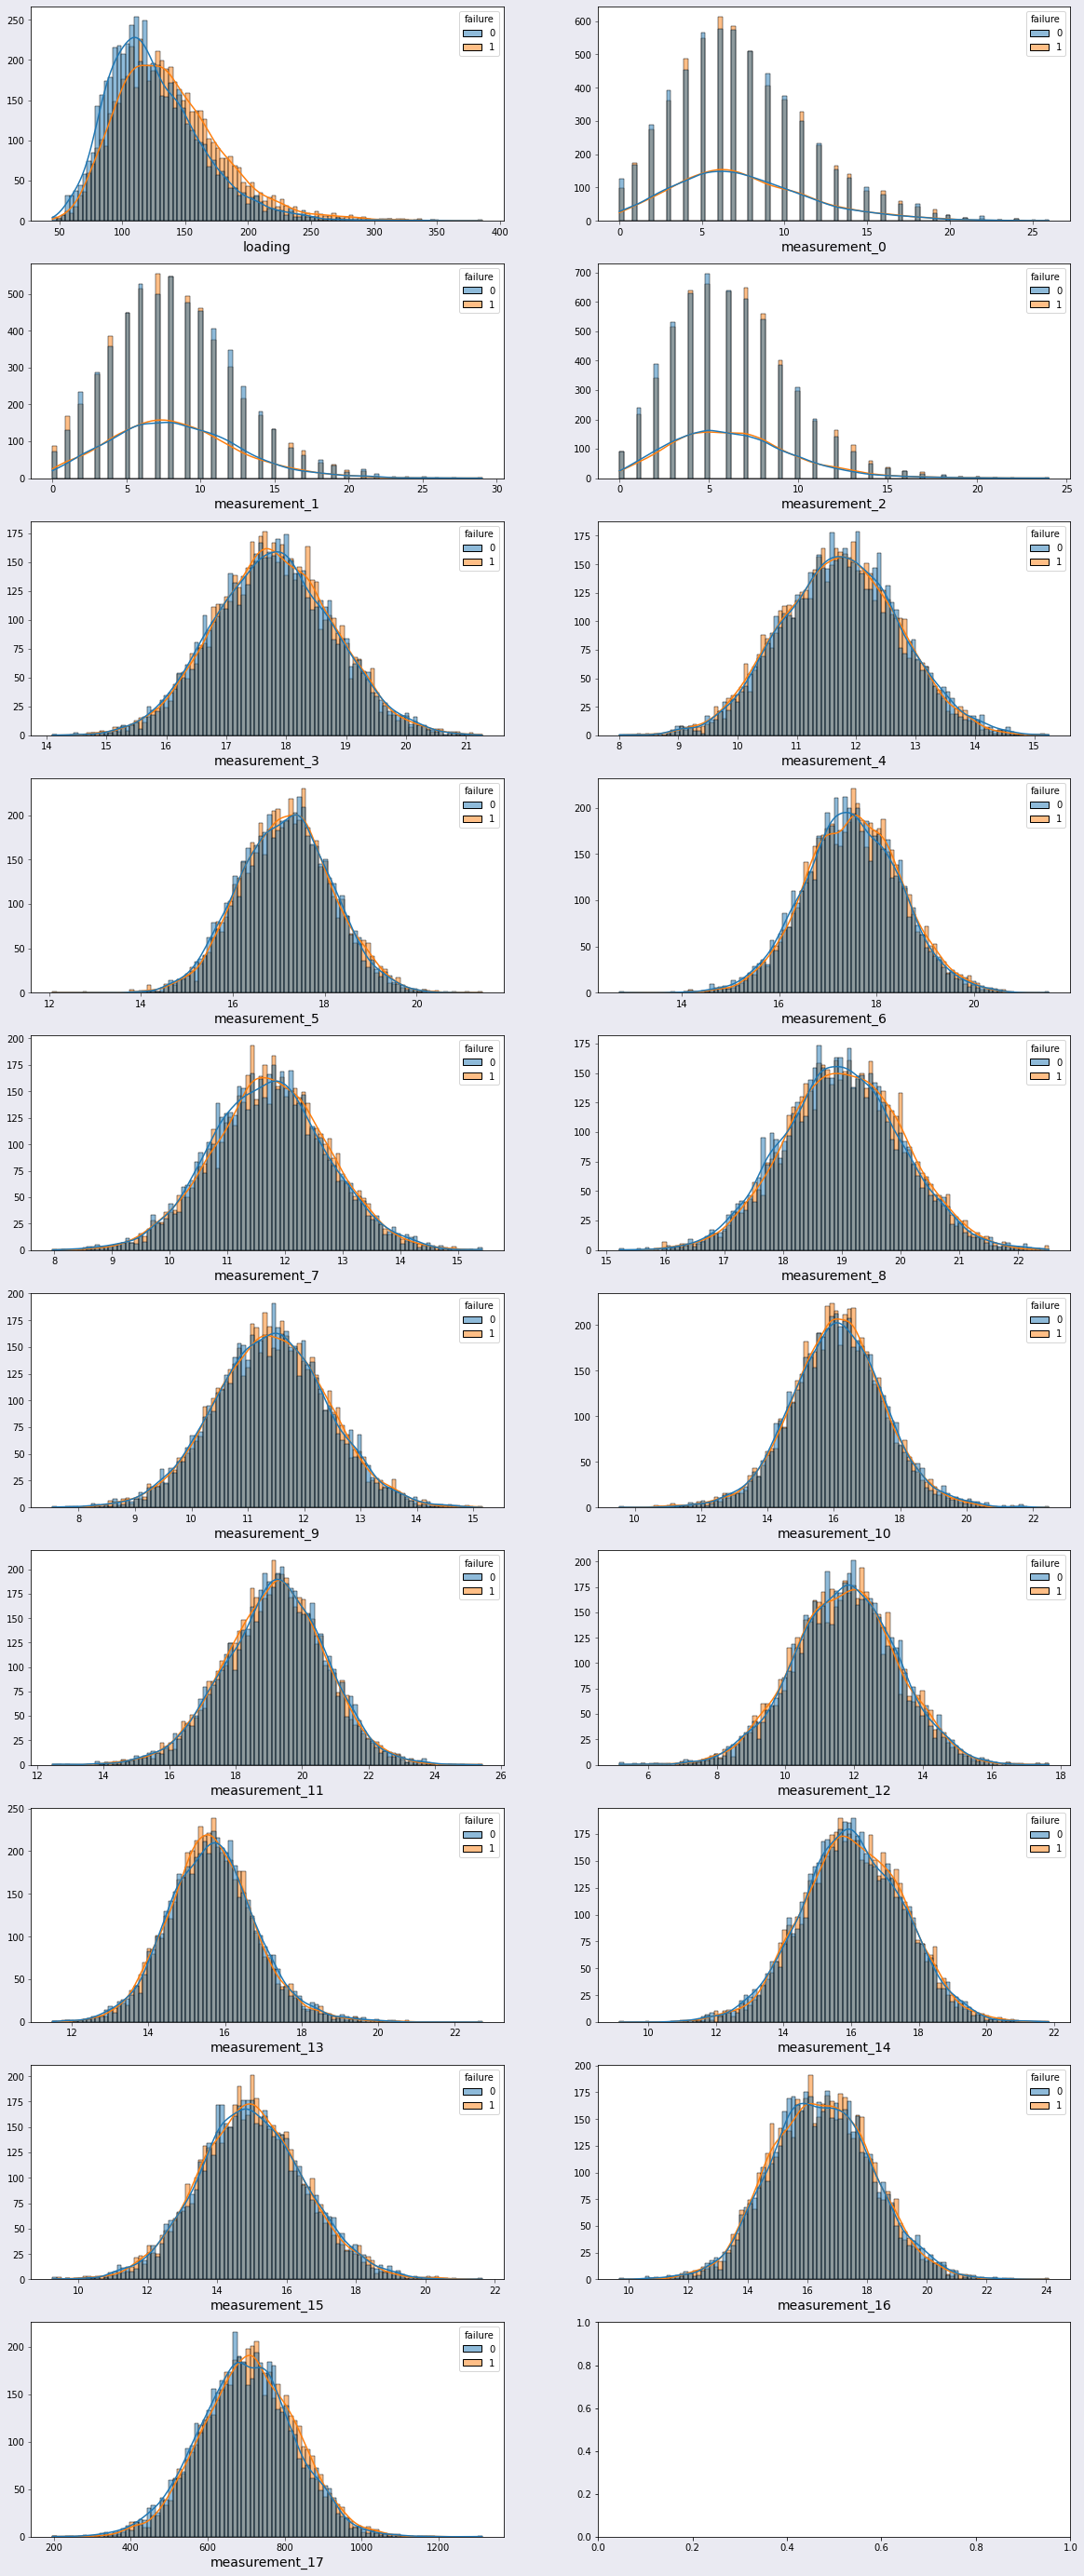

In [ ]:
col_list_1=num_features
ncols = 2
nrows = 10

fig, axes = plt.subplots(nrows, ncols, figsize=(20,50), facecolor='#EAEAF2')

for r in range(nrows):
    for c in range(ncols):
        col = col_list_1[r*ncols+c]
        sns.histplot(df_plot,x=col, bins=100, kde=True, hue='failure', legend=True,ax=axes[r, c])
        axes[r, c].set_ylabel('')
        axes[r, c].set_xlabel(col, fontsize=14)
        axes[r, c].tick_params(labelsize=10, width=0.5)
        axes[r, c].xaxis.offsetText.set_fontsize(20)
        axes[r, c].yaxis.offsetText.set_fontsize(20)
plt.show()

In [ ]:
#df_test['measurement_1'].unique().tolist() in df_org['measurement_1'].unique().tolist()
#df_test['measurement_2'].unique()
l=[x for x in df_test['measurement_1'].unique().tolist() if x in df_org['measurement_1'].unique().tolist()]
np.array(l)

array([ 9,  8, 12, 11, 16, 18,  7, 15, 19, 10, 13,  6, 14,  5,  2,  4, 17,
       25, 22, 21, 23,  3, 20, 26, 24, 27, 28,  1, 29,  0])

In [ ]:
df_test['measurement_1'].unique()

array([ 9,  8, 12, 11, 16, 18,  7, 15, 19, 10, 13,  6, 14,  5,  2,  4, 17,
       25, 22, 21, 23,  3, 20, 26, 24, 31, 27, 28,  1, 29, 33, 32,  0])

In [ ]:
numeric_transformer = Pipeline(steps=[
                    ('imputer', SimpleImputer(strategy='median')),
                    ('scaler', RobustScaler())])

In [ ]:
numeric_transformer2 = Pipeline(steps=[
                    ('imputer', CustomKnnImputer()),
                     ( 'new_features',AddNewFeatures())])

In [ ]:
num_features_for_trans = ['measurement_3', 'measurement_4', 'measurement_5', 'measurement_6',
                'measurement_7', 'measurement_8', 'measurement_9', 'measurement_10',
                'measurement_11', 'measurement_12', 'measurement_13', 'measurement_14',
                'measurement_15', 'measurement_16', 'measurement_17','loading']
new_discrete_features = ['loading_bin', 'measurement_3_bin', 'measurement_4_bin', 'measurement_5_bin', 'measurement_6_bin',
                'measurement_7_bin', 'measurement_8_bin', 'measurement_9_bin', 'measurement_10_bin',
                'measurement_11_bin', 'measurement_12_bin', 'measurement_13_bin', 'measurement_14_bin',
                'measurement_15_bin', 'measurement_16_bin', 'measurement_17_bin']

#all_discrete_features=['measurement_0', 'measurement_1', 'measurement_2'] + num_features_for_trans

all_num_features= ['measurement_0', 'measurement_1', 'measurement_2']+num_features_for_trans

In [ ]:
X=df_org[features]
y=df_org['failure']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2,
                                                    random_state=2,
                                                    stratify=y)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, 
                                                      test_size=0.2,
                                                      random_state=2,
                                                      stratify=y_train)

print(f"shape of X_train: {X_train.shape}")
print(f"shape of X_valid: {X_valid.shape}")
print(f"shape of X_test: {X_test.shape}")

print(f"shape of y_train: {y_train.shape}")
print(f"shape of y_valid: {y_valid.shape}")
print(f"shape of y_test: {y_test.shape}")

shape of X_train: (17004, 21)
shape of X_valid: (4252, 21)
shape of X_test: (5314, 21)
shape of y_train: (17004,)
shape of y_valid: (4252,)
shape of y_test: (5314,)


In [ ]:
X_train_num = numeric_transformer.fit_transform(X_train[num_features])
X_valid_num = numeric_transformer.transform(X_valid[num_features])
X_test_num = numeric_transformer.transform(X_test[num_features])

X_train_num = pd.DataFrame(X_train_num,columns=num_features)
X_valid_num = pd.DataFrame(X_valid_num,columns=num_features)
X_test_num = pd.DataFrame(X_test_num,columns=num_features)

X_train=pd.concat([X_train_num,X_train[cat_features].reset_index(drop=True)],axis=1)
X_valid=pd.concat([X_valid_num,X_valid[cat_features].reset_index(drop=True)],axis=1)
X_test=pd.concat([X_test_num,X_test[cat_features].reset_index(drop=True)],axis=1)

print(f"shape of X_train: {X_train.shape}")
print(f"shape of X_valid: {X_valid.shape}")
print(f"shape of X_test: {X_test.shape}")




shape of X_train: (17004, 21)
shape of X_valid: (4252, 21)
shape of X_test: (5314, 21)


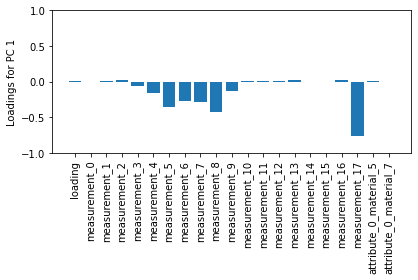

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
# initializing the PCA transformer and

pca = PCA(n_components=2).fit(X_train)


#plt.plot(np.cumsum(pca.explained_variance_ratio_))
#plt.xlabel('number of components')
#plt.ylabel('cumulative explained variance')
sklearn_loadings = pca.components_.T * np.sqrt(pca.explained_variance_)


fig, ax = plt.subplots()
ax.bar(range(21), sklearn_loadings[:, 0], align='center')
ax.set_ylabel('Loadings for PC 1')
ax.set_xticks(range(21))
ax.set_xticklabels(features, rotation=90)
plt.ylim([-1, 1])
plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots()
ax.bar(range(13), sklearn_loadings[:, 0], align='center')
ax.set_ylabel('Loadings for PC 1')
ax.set_xticks(range(13))
ax.set_xticklabels(features, rotation=90)
plt.ylim([-1, 1])
plt.tight_layout()
plt.show()

In [ ]:
clf = TabNetClassifier(
    n_d=24, n_a=24)

Device used : cuda


In [ ]:
clf = TabNetClassifier(
    n_d=32, n_a=32, n_steps=5,
    gamma=1.5, n_independent=2, n_shared=2,
    lambda_sparse=1e-4, momentum=0.3, clip_value=2.,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params = {"gamma": 0.95,
                     "step_size": 20},
    scheduler_fn=torch.optim.lr_scheduler.StepLR, epsilon=1e-15
)

Device used : cpu


In [ ]:
max_epochs = 100 if not os.getenv("CI", False) else 2

In [ ]:
y_train.shape

(17801,)

In [ ]:
#aug = ClassificationSMOTE(p=0.2)

clf.fit(
    X_train=X_train_final.values, y_train=y_train.values,
    eval_set=[(X_train_final.values, y_train.values), (X_test_final.values, y_test.values)],
    eval_name=['train', 'test'],
    max_epochs=max_epochs, patience=100,
    batch_size=5000, virtual_batch_size=512,
    
) 

epoch 0  | loss: 0.64562 | train_auc: 0.49659 | test_auc: 0.49651 |  0:00:00s
epoch 1  | loss: 0.54246 | train_auc: 0.54311 | test_auc: 0.54853 |  0:00:00s
epoch 2  | loss: 0.52166 | train_auc: 0.538   | test_auc: 0.51946 |  0:00:01s
epoch 3  | loss: 0.51478 | train_auc: 0.5309  | test_auc: 0.50132 |  0:00:01s
epoch 4  | loss: 0.51417 | train_auc: 0.53651 | test_auc: 0.50846 |  0:00:02s
epoch 5  | loss: 0.51291 | train_auc: 0.54002 | test_auc: 0.52408 |  0:00:02s
epoch 6  | loss: 0.51296 | train_auc: 0.56802 | test_auc: 0.5552  |  0:00:03s
epoch 7  | loss: 0.51155 | train_auc: 0.58211 | test_auc: 0.56065 |  0:00:03s
epoch 8  | loss: 0.51112 | train_auc: 0.5774  | test_auc: 0.5585  |  0:00:04s
epoch 9  | loss: 0.51072 | train_auc: 0.56941 | test_auc: 0.55643 |  0:00:04s
epoch 10 | loss: 0.5104  | train_auc: 0.56403 | test_auc: 0.55345 |  0:00:05s
epoch 11 | loss: 0.51031 | train_auc: 0.5739  | test_auc: 0.56135 |  0:00:05s
epoch 12 | loss: 0.50965 | train_auc: 0.57826 | test_auc: 0.5649

In [ ]:
y_preds = clf.predict_proba(X_test_final.values)[:,1]
y_true = y_test.values
roc_auc=roc_auc_score(y_true,y_preds)
print(f"roc_auc: {roc_auc}")

#roc_auc: 0.5213860429110475 with n_d 64
#roc_auc: 0.5636580145180121 n_d 32
#roc_auc: 0.5525182321189868 n_d 16

roc_auc: 0.5810564823648969
